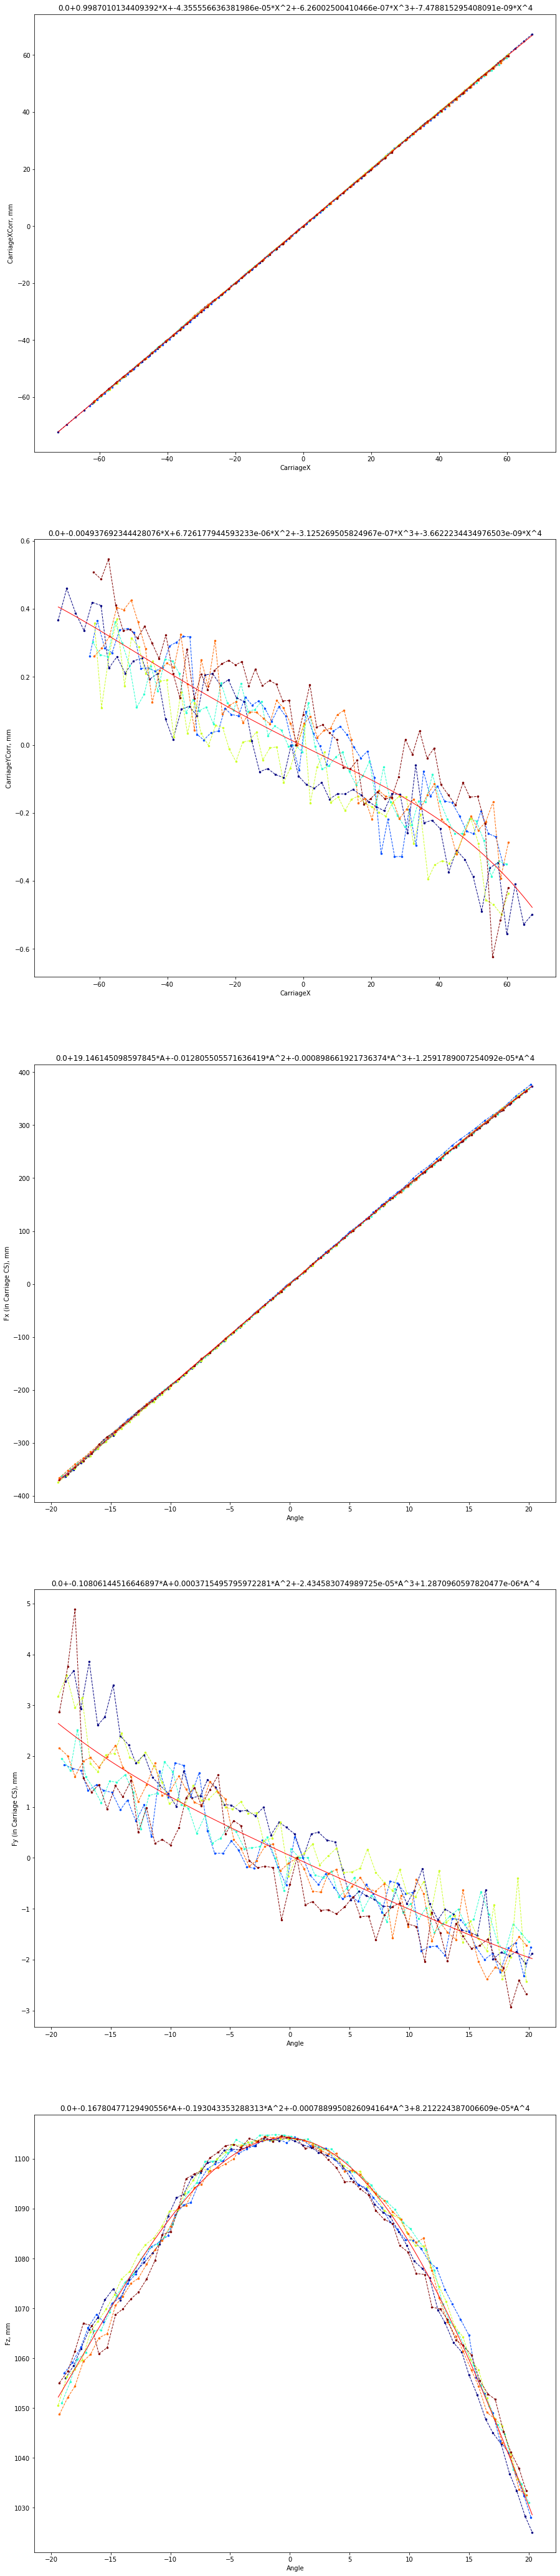

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
import csv
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.preprocessing import PolynomialFeatures
#from scipy.optimize import minimize

ScriptVersion = 'v1.0'

# Директория с исходными данными:
DataDir = 'C:\\Users\\shue.MTL\\Projects\\Get_Tomo_Correction'

# Чтение данных для коррекции:
Files = []
for Roots, Dirnames, Filenames in os.walk(DataDir):
    for Filename in Filenames:
        if ('.csv' in Filename) and ('SE' in Filename):
            Files.append(os.path.join(Roots, Filename))


plt.rcParams["figure.figsize"] = (15,75)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,len(Files))))

DataArr = np.array([])

for Filename in Files[::1]:
    CorrData = pd.read_csv(Filename)
    
    # Значения Carriage, записанные в .csv получаются из значений координат каретки  в теге 
    # [0x4f33, 0xe781] в dicom-файле с проекционными данными с помощью следующей интерполяции:
    # Carriage = np.interp(0, Angles, Carriage) - Carriage
    # - чтобы при угле наклона 0 каретка проходила через Х=0
    # затем в ходе рассчетов вводится переменная DetLocation:
    # DetLocation = np.array([Carriage[i]-(0.5*DetSize[0]-0.5)*DetSpace[0], 
    #                       -(0.5*DetSize[1]-0.5)*DetSpace[1], 
    #                       0])
    # - XYZ координаты центра пикселя (0, 0)
    # В .csv записаны DetX и DetY - это DetLocation[0] и DetLocation[1],
    # DetXCorr и DetYCorr - их скорректированные значения.
    # Чтобы было удобней использовать полученные результаты, я от координат центра пикселя (0, 0)
    # перейду к координатам центра детектора (который при угле наклона 0 должен проходить через Х=0)
    
    DetSize = np.array([1440, 1440])
    DetSpace = np.array([0.296, 0.296])
    
    CarriageX = np.array(CorrData['DetX'] + (0.5*DetSize[0]-0.5)*DetSpace[0])
    CarriageY = np.array(CorrData['DetY'] + (0.5*DetSize[1]-0.5)*DetSpace[1])
    CarriageXCorr = np.array(CorrData['DetXCorr'] + (0.5*DetSize[0]-0.5)*DetSpace[0])
    CarriageYCorr = np.array(CorrData['DetYCorr'] + (0.5*DetSize[1]-0.5)*DetSpace[1])
    
    Angles = np.array(CorrData['Angles'])
    # Координаты фокуса зависят от угла наклона колонны и от координат каретки (т.к. трубка 
    # физически) соединена с кареткой. Однако координаты фокуса в системе координат, связанной 
    # с кареткой, зависят только от угла наклона колонны. Поэтому перейдем в СК каретки.
    FX = np.array(CorrData['FX']) - CarriageX
    FY = np.array(CorrData['FY']) - CarriageY
    FZ = np.array(CorrData['FZ'])
    FXCorr = np.array(CorrData['FXCorr']) - CarriageXCorr
    FYCorr = np.array(CorrData['FYCorr']) - CarriageYCorr
    FZCorr = np.array(CorrData['FZCorr'])
    
    # Визуализация:
    color=next(colors)
    ax1.plot(CarriageX, CarriageXCorr, color=color, marker='.', linestyle='dashed',linewidth=1, markersize=5)
    ax2.plot(CarriageX, CarriageYCorr, color=color, marker='.', linestyle='dashed',linewidth=1, markersize=5)
    ax3.plot(Angles, FXCorr, color=color, marker='.', linestyle='dashed',linewidth=1, markersize=5)
    ax4.plot(Angles, FYCorr, color=color, marker='.', linestyle='dashed',linewidth=1, markersize=5)
    ax5.plot(Angles, FZCorr, color=color, marker='.', linestyle='dashed',linewidth=1, markersize=5)
    
    # Собираем точки со всех серий измерений в один массив:
    if DataArr.size==0:
        DataArr = np.vstack((CarriageX, CarriageY, CarriageXCorr, CarriageYCorr, 
                             Angles, FX, FY, FZ, FXCorr, FYCorr, FZCorr))
    else:
        DataArr = np.hstack((DataArr, np.vstack((CarriageX, CarriageY, CarriageXCorr, CarriageYCorr, 
                                                 Angles, FX, FY, FZ, FXCorr, FYCorr, FZCorr))))

CarriageX = np.linspace(np.min(DataArr[0,:]), np.max(DataArr[0,:]), 100)
Angles = np.linspace(np.min(DataArr[4,:]), np.max(DataArr[4,:]), 100)

poly = PolynomialFeatures(degree = 4)

CarriageX_Poly = poly.fit_transform(CarriageX.reshape((-1, 1)))
Angles_Poly = poly.fit_transform(Angles.reshape((-1, 1)))

CX_poly = poly.fit_transform(DataArr[0,:].reshape((-1, 1)))
A_poly = poly.fit_transform(DataArr[4,:].reshape((-1, 1)))

# Найдем коэфф. полиномов, связывающих измеренные величины с уточненными координатами:
# CarriageXCorr = F1(CarriageX):
poly.fit(CX_poly, DataArr[2,:])
lin1 = LinearRegression()
#TSR1 = TheilSenRegressor()
lin1.fit(CX_poly, DataArr[2,:])
#TSR1.fit(CX_poly, DataArr[2,:])
# CarriageYCorr = F2(CarriageX):
poly.fit(CX_poly, DataArr[3,:])
lin2 = LinearRegression()
lin2.fit(CX_poly, DataArr[3,:])
# FXCorr = F3(Angle):
poly.fit(A_poly, DataArr[8,:])
lin3 = LinearRegression()
lin3.fit(A_poly, DataArr[8,:])
# FYCorr = F4(Angle):
poly.fit(A_poly, DataArr[9,:])
lin4 = LinearRegression()
lin4.fit(A_poly, DataArr[9,:])
# FZCorr = F5(Angle):
poly.fit(A_poly, DataArr[10,:])
lin5 = LinearRegression()
lin5.fit(A_poly, DataArr[10,:])

# Запись результатов (координаты фокуса в СК каретки!):
Results = {'Poly4Coef_CarX2CarXCorr': lin1.coef_,
           'Poly4Coef_CarX2CarYCorr': lin2.coef_,
           'Poly4Coef_Angle2FXCorr': lin3.coef_,
           'Poly4Coef_Angle2FYCorr': lin4.coef_,
           'Poly4Coef_Angle2FZCorr': lin5.coef_}
pd.DataFrame(Results).to_csv('Poly4Coef.csv', encoding='utf-8', index=False)

# Визуализация результатов:
# CarriageXCorr(CarriageX):
ax1.plot(CarriageX, lin1.predict(CarriageX_Poly), color = 'red', linewidth=1)
ax1.set_title(str(lin1.coef_[0]) + '+' + str(lin1.coef_[1]) + '*X+' + str(lin1.coef_[2]) + '*X^2+' + \
              str(lin1.coef_[3]) + '*X^3+' + str(lin1.coef_[4]) + '*X^4')
# CarriageYCorr(CarriageX):
ax2.plot(CarriageX, lin2.predict(CarriageX_Poly), color = 'red', linewidth=1)
ax2.set_title(str(lin2.coef_[0]) + '+' + str(lin2.coef_[1]) + '*X+' + str(lin2.coef_[2]) + '*X^2+' + \
              str(lin2.coef_[3]) + '*X^3+' + str(lin2.coef_[4]) + '*X^4')
# FXCorr(Angle):
ax3.plot(Angles, lin3.predict(Angles_Poly), color = 'red', linewidth=1)
ax3.set_title(str(lin3.coef_[0]) + '+' + str(lin3.coef_[1]) + '*A+' + str(lin3.coef_[2]) + \
              '*A^2+' + str(lin3.coef_[3]) + '*A^3+' + str(lin3.coef_[4]) + '*A^4')
# FYCorr(Angle):
ax4.plot(Angles, lin4.predict(Angles_Poly), color = 'red', linewidth=1)
ax4.set_title(str(lin4.coef_[0]) + '+' + str(lin4.coef_[1]) + '*A+' + str(lin4.coef_[2]) + \
              '*A^2+' + str(lin4.coef_[3]) + '*A^3+' + str(lin4.coef_[4]) + '*A^4')
# FZCorr(Angle):
ax5.plot(Angles, lin5.predict(Angles_Poly), color = 'red', linewidth=1)
ax5.set_title(str(lin5.coef_[0]) + '+' + str(lin5.coef_[1]) + '*A+' + str(lin5.coef_[2]) + \
              '*A^2+' + str(lin5.coef_[3]) + '*A^3+' + str(lin5.coef_[4]) + '*A^4')

ax1.set(xlabel='CarriageX', ylabel='CarriageXCorr, mm')
ax2.set(xlabel='CarriageX', ylabel='CarriageYCorr, mm')
ax3.set(xlabel='Angle', ylabel='Fx (in Carriage CS), mm')
ax4.set(xlabel='Angle', ylabel='Fy (in Carriage CS), mm')
ax5.set(xlabel='Angle', ylabel='Fz, mm')

plt.show()
#####################

In [34]:
CorrData

,Angles,Carriage,SID,FX,FY,FZ,DetX,DetY,FXCorr,FYCorr,FZCorr,DetXCorr,DetYCorr
0,-19.3,60.4,1104.0,-304.487890,0.0,1041.956251,-152.572003,-212.972003,-310.499808,2.448618,1055.088570,-153.235264,-213.391714
1,-18.6,58.1,1104.0,-294.031077,0.0,1046.336325,-154.872003,-212.972003,-301.367197,3.245954,1057.440846,-155.124021,-213.487987
2,-18.0,55.8,1104.0,-285.354762,0.0,1049.966394,-157.172003,-212.972003,-290.784988,4.259665,1061.453923,-157.537429,-213.595971
3,-17.3,53.6,1104.0,-274.701861,0.0,1054.055923,-159.372003,-212.972003,-281.185473,1.339950,1066.986609,-159.565974,-213.204071
4,-16.6,51.4,1104.0,-263.999958,0.0,1057.988122,-161.572003,-212.972003,-269.419835,1.138339,1066.589284,-161.701366,-213.123526
5,-16.0,49.1,1104.0,-255.203641,0.0,1061.232912,-163.872003,-212.972003,-253.896421,1.288709,1060.899023,-164.231122,-213.125592
6,-15.3,47.1,1104.0,-244.215847,0.0,1064.871390,-165.872003,-212.972003,-241.479944,0.854154,1062.142451,-166.395991,-213.083152
7,-14.6,44.9,1104.0,-233.384572,0.0,1068.350924,-168.072003,-212.972003,-234.395443,1.243112,1068.785002,-168.299319,-213.149487
8,-14.0,42.8,1104.0,-224.281773,0.0,1071.206482,-170.172003,-212.972003,-223.628590,1.051175,1069.855636,-170.353250,-213.119586
9,-13.3,40.6,1104.0,-213.374910,0.0,1074.389476,-172.372003,-212.972003,-213.037100,1.403802,1071.940147,-172.556108,-213.088772


In [108]:
pd.DataFrame(Results)

,Poly4Coef_CarX2CarXCorr,Poly4Coef_CarX2CarYCorr,Poly4Coef_Angle2FXCorr,Poly4Coef_Angle2FYCorr,Poly4Coef_Angle2FZCorr
0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
1,9.987010e-01,-4.937692e-03,19.146145,-0.108061,-0.167805
2,-4.355557e-05,6.726178e-06,-0.012806,0.000372,-0.193043
3,-6.260025e-07,-3.125270e-07,-0.000899,-0.000024,-0.000789
4,-7.478815e-09,-3.662223e-09,-0.000013,0.000001,0.000082
